# CVAE model for anomaly detection on stock data

In [389]:
import pandas as pd  
import matplotlib.pyplot as plt
import datetime, random
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer, Input, Dense, Lambda, concatenate
from tensorflow.keras.layers import Layer, Input, Dense, Concatenate
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.regularizers import l2
%matplotlib inline

## Data preparation

The dataset is stock market data from the $S\&P 500$ index covering a period of five years from January 2, 2019, to December 29, 2023. Each entry in the dataset for a specific stock symbol includes the following features:

- **Date**: The trading date.
- **Symbol**: The stock ticker symbol.
- **Adj Close**: The adjusted closing price of the stock for the day, which accounts for all corporate actions such as stock splits, dividends, and rights offerings.
- **Close**: The raw closing price of the stock at the end of the trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Open**: The price at which the stock first traded upon the opening of the exchange.
- **Volume**: The number of shares that changed hands during the trading day.


In [390]:
stock_data_file = 'sp500_filtered.csv'
stocks_df = pd.read_csv(stock_data_file, parse_dates=['Date'])
print(stocks_df.head())
print('Stocks found:', len(set(stocks_df['Symbol'])))
print('Date range:', str(np.min(stocks_df['Date']))[:10], '-', str(np.max(stocks_df['Date']))[:10])

        Date Symbol   Adj Close       Close        High         Low  \
0 2019-01-02    MMM  122.182953  159.657196  159.690628  156.103683   
1 2019-01-03    MMM  117.582321  153.645493  157.424744  152.918060   
2 2019-01-04    MMM  122.419769  159.966553  160.518402  155.543472   
3 2019-01-07    MMM  122.138176  159.598663  160.785950  157.742477   
4 2019-01-08    MMM  122.650085  160.267563  162.299332  158.511703   

         Open     Volume  
0  157.040131  2960339.0  
1  157.424744  4016407.0  
2  156.145493  3582140.0  
3  160.000000  2585991.0  
4  161.371231  2965841.0  
Stocks found: 503
Date range: 2019-01-02 - 2023-12-29


To ensure data and integrity check for missing values and calculate the percentage of it.

In [391]:
missing_values = stocks_df.isnull().sum()
print(missing_values)
total_rows = len(stocks_df)
missing_percentage = (stocks_df.isnull().sum() / total_rows) * 100
print(missing_percentage)


Date            0
Symbol          0
Adj Close    8006
Close        8006
High         8006
Low          8006
Open         8006
Volume       8006
dtype: int64
Date         0.000000
Symbol       0.000000
Adj Close    1.265223
Close        1.265223
High         1.265223
Low          1.265223
Open         1.265223
Volume       1.265223
dtype: float64


Given that the missing data constitutes approximately 1.27% of the dataset, it can be managed through straightforward data cleaning methods like Forward Fill and Backward Fill without risking significant distortion in your analysis.

In [392]:
stocks_df.fillna(method='ffill', inplace=True)
stocks_df.fillna(method='bfill', inplace=True) 
print(stocks_df.isnull().sum())


Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


Enrich the dataset with the extraction of additional Temporal Features; Days of the week and month were derived from the date to capture potential temporal cycles affecting stock prices.

In [393]:
stocks_df['Day'] = stocks_df['Date'].dt.weekday
stocks_df['Day_of_month'] = stocks_df['Date'].dt.day

max_day_of_month = 31  # maximum day in month
max_day_of_week = 7    # maximum day in week


stocks_df.head()


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Day,Day_of_month
0,2019-01-02,MMM,122.182953,159.657196,159.690628,156.103683,157.040131,2960339.0,2,2
1,2019-01-03,MMM,117.582321,153.645493,157.424744,152.918060,157.424744,4016407.0,3,3
2,2019-01-04,MMM,122.419769,159.966553,160.518402,155.543472,156.145493,3582140.0,4,4
3,2019-01-07,MMM,122.138176,159.598663,160.785950,157.742477,160.000000,2585991.0,0,7
4,2019-01-08,MMM,122.650085,160.267563,162.299332,158.511703,161.371231,2965841.0,1,8


To focus our analysis we specifically target stocks from the Dow 30 index. This selection helps to standardize our dataset, concentrating on major companies with stable financial histories and significant market influence. 

In [394]:
stock_symbols = list(set(stocks_df['Symbol']))

# List of Dow 30 symbols
dow_30_list = ['NKE', 'AXP', 'BA', 'C', 'CAT', 'DD', 'DIS', 'GE', 'CSCO', 'HD', 'CVX', 'V', 'IBM',
               'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'GS', 'MRK', 'MSFT', 'PFE', 'PG', 'AAPL', 
               'UTX', 'VZ', 'WMT', 'XOM', 'TRV']

# Intersection of the Dow 30 list with the stock symbols in your dataset
dow_30_symbols = list(set(dow_30_list) & set(stock_symbols))

print(f"Covered Dow 30 stocks: {len(dow_30_symbols)} out of 30")

Covered Dow 30 stocks: 29 out of 30


IIn this section we are adding computed features that help to capture market dynamics and stock behavior more effectively. The added features are:

- **Rolling Averages:** Compute the average closing price over the past 3, 5, and 10 days (`Close_Avg_3`, `Close_Avg_5`, `Close_Avg_10`). These features help in identifying the trend direction and smoothing out price data over a specified period.

- **Volatility Measurement:** Calculate the standard deviation of the closing prices over a 5-day window (`Volatility_5`). This measure indicates the variability or risk associated with the stock price changes within that period.

- **Relative Position Indicator:** This feature (`Relative_Pos`) evaluates the closing price's position within the day's range. It's computed as `(Close - Low) / (High - Low)`, providing insights into whether the closing price was nearer to the high or low of the day.

- **Volume Change:** The percentage change in trading volume from the previous day (`Volume_Change`) is crucial for understanding the strength behind a price movement.

- **Open to Close Change:** The difference between the opening and closing prices (`Open_Close_Change`) offers insights into intra-day price movements.

They provide a deeper insight into the stock's daily and short-term behaviors, enhancing the predictive capabilities of the model.


In [395]:
market_data = {}
for symbol in dow_30_symbols:
    # Extract data for the specific stock and sort by date to ensure correct calculations
    temp_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
    temp_df.sort_values('Date', inplace=True)
    
    # Calculate rolling metrics to capture trends and volatility
    temp_df['Close_Avg_3'] = temp_df['Close'].rolling(window=3).mean()
    temp_df['Close_Avg_5'] = temp_df['Close'].rolling(window=5).mean()
    temp_df['Close_Avg_10'] = temp_df['Close'].rolling(window=10).mean()
    temp_df['Volatility_5'] = temp_df['Close'].rolling(window=5).std()
    temp_df['Relative_Pos'] = (temp_df['Close'] - temp_df['Low']) / (temp_df['High'] - temp_df['Low'])
    temp_df['Volume_Change'] = temp_df['Volume'].pct_change()
    temp_df['Open_Close_Change'] = temp_df['Close'] - temp_df['Open']
    
    # Store processed data in a dictionary
    market_data[symbol] = temp_df[['Open', 'High', 'Low', 'Close', 'Volume',
                                   'Close_Avg_3', 'Close_Avg_5', 'Close_Avg_10', 
                                   'Volatility_5', 'Relative_Pos', 'Volume_Change', 
                                   'Open_Close_Change', 'Day', 'Day_of_month', 'Date']]


Rebuilding the DataFrame with the new features.

In [396]:
fin_Open = []
fin_High = []
fin_Low = []
fin_Close = []
fin_Volume = []
fin_Close_Avg_3 = []
fin_Close_Avg_5 = []
fin_Close_Avg_10 = []
fin_Volatility_5 = []
fin_Relative_Pos = []
fin_Volume_Change = []
fin_Open_Close_Change = []

fin_Day = []
fin_Day_of_month = []
fin_Date = []
fin_Symbol = []

for key, df in market_data.items():
    fin_Open.extend(df['Open'].tolist())
    fin_High.extend(df['High'].tolist())
    fin_Low.extend(df['Low'].tolist())
    fin_Close.extend(df['Close'].tolist())
    fin_Volume.extend(df['Volume'].tolist())
    fin_Close_Avg_3.extend(df['Close_Avg_3'].tolist())
    fin_Close_Avg_5.extend(df['Close_Avg_5'].tolist())
    fin_Close_Avg_10.extend(df['Close_Avg_10'].tolist())
    fin_Volatility_5.extend(df['Volatility_5'].tolist())
    fin_Relative_Pos.extend(df['Relative_Pos'].tolist())
    fin_Volume_Change.extend(df['Volume_Change'].tolist())
    fin_Open_Close_Change.extend(df['Open_Close_Change'].tolist())
    fin_Day.extend(df['Day'].tolist())
    fin_Day_of_month.extend(df['Day_of_month'].tolist())
    fin_Date.extend(df['Date'].tolist())
    fin_Symbol.extend([key] * len(df))

# Build final DataFrame
norm_stocks_df = pd.DataFrame({
    'Symbol': fin_Symbol,
    'Open': fin_Open,
    'High': fin_High,
    'Low': fin_Low,
    'Close': fin_Close,
    'Volume': fin_Volume,
    'Close_Avg_3': fin_Close_Avg_3,
    'Close_Avg_5': fin_Close_Avg_5,
    'Close_Avg_10': fin_Close_Avg_10,
    'Volatility_5': fin_Volatility_5,
    'Relative_Pos': fin_Relative_Pos,
    'Volume_Change': fin_Volume_Change,
    'Open_Close_Change': fin_Open_Close_Change,
    'Day': fin_Day,
    'Day_of_month': fin_Day_of_month,
    'Date': fin_Date,
    'Raw_volume': fin_Volume,
    'Raw_open_close': fin_Open_Close_Change,
    'Raw_close': fin_Close
})

# Replace infinities and drop rows with any missing values
norm_stocks_df = norm_stocks_df.replace([np.inf, -np.inf], np.nan).dropna()

print(norm_stocks_df.head())


   Symbol       Open       High        Low      Close      Volume  \
9      GE  42.700619  42.796467  41.694206  41.837978  19626381.0   
10     GE  41.742130  43.131935  41.502506  43.036087  17583057.0   
11     GE  42.652695  44.042500  41.933826  43.802879  22074822.0   
12     GE  44.234196  44.330048  43.275711  43.419483  19350175.0   
13     GE  43.036087  43.084011  41.023266  41.502506  22571396.0   

    Close_Avg_3  Close_Avg_5  Close_Avg_10  Volatility_5  Relative_Pos  \
9     42.445021    42.183035     41.047227      0.909554      0.130434   
10    42.508920    42.643108     41.492923      0.470050      0.941177   
11    42.892315    42.834806     42.010507      0.707920      0.886364   
12    43.419483    42.949825     42.408279      0.755018      0.136363   
13    42.908290    42.719787     42.369939      1.002755      0.232557   

    Volume_Change  Open_Close_Change  Day  Day_of_month       Date  \
9        0.151572          -0.862640    1            15 2019-01-15   


Creating a subset of features that will be normalized and used in the training.

In [397]:
# List of columns to be used in modeling, excluding identifiers and raw data not used in training
features = [f for f in list(norm_stocks_df) if f not in ['Date', 'Symbol', 'Raw_close', 'Raw_open_close', 'Raw_volume']]
cyclic_features = ['Day_of_month_sin', 'Day_of_month_cos', 'Day_sin', 'Day_cos']
df = norm_stocks_df.copy()

# Take all numerical cols and normalize data b/w 0 and 1
df[features] = df[features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


print("Selected features for normalization and training:", features)


Selected features for normalization and training: ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_Avg_3', 'Close_Avg_5', 'Close_Avg_10', 'Volatility_5', 'Relative_Pos', 'Volume_Change', 'Open_Close_Change', 'Day', 'Day_of_month']


This section includes the application of PCA to the dataset to explore the dimensionality of the feature space and to identify how many principal components might be necessary to capture most of the variance in the data. This is important as it helps in understanding the underlying structure of the data.

Given that more than 90% of the variance is explained by the first two components, using two dimensions for the latent space would likely be sufficient for capturing the critical features of the dataset without significant loss of information. 

The additional checks for missing values and data normalization ensure the data's readiness for further analysis or model training.

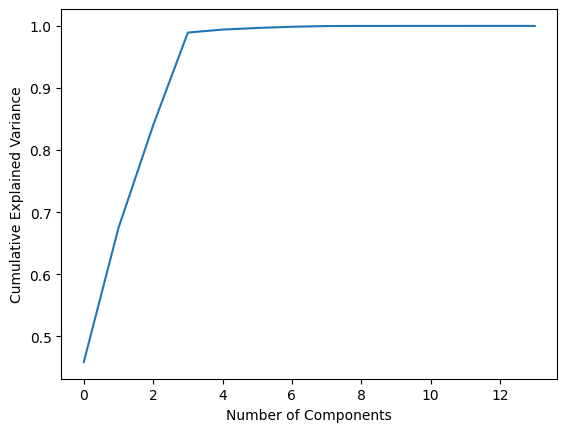

No missing data found.
Data successfully normalized between 0 and 1.


In [398]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(df[features])  # data_normalized should be your preprocessed data
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


# Check for any remaining missing values
if df.isnull().any().any():
    print("Warning: There are missing values in the DataFrame.")
else:
    print("No missing data found.")

# Verify the scale of the features
if (df[features].min().min() < 0) or (df[features].max().max() > 1):
    print("Warning: Data not properly normalized.")
else:
    print("Data successfully normalized between 0 and 1.")



##### Correlation Matrix Analysis

The correlation matrix provides insights into how different features relate to each other. The Open, High, Low, and Close values show a perfect correlation (1.00), which is expected as these features are all directly related to the stock's price action within the same day.
So we will only include the variable close.

The moving averages (Close_Avg_3, Close_Avg_5, Close_Avg_10) are also perfectly correlated with the raw price features. This suggests that these derived metrics, intended to smooth out price fluctuations and highlight trends, do not diverge significantly from the actual price movements on a daily basis. For this reason these will not be in the trining process.

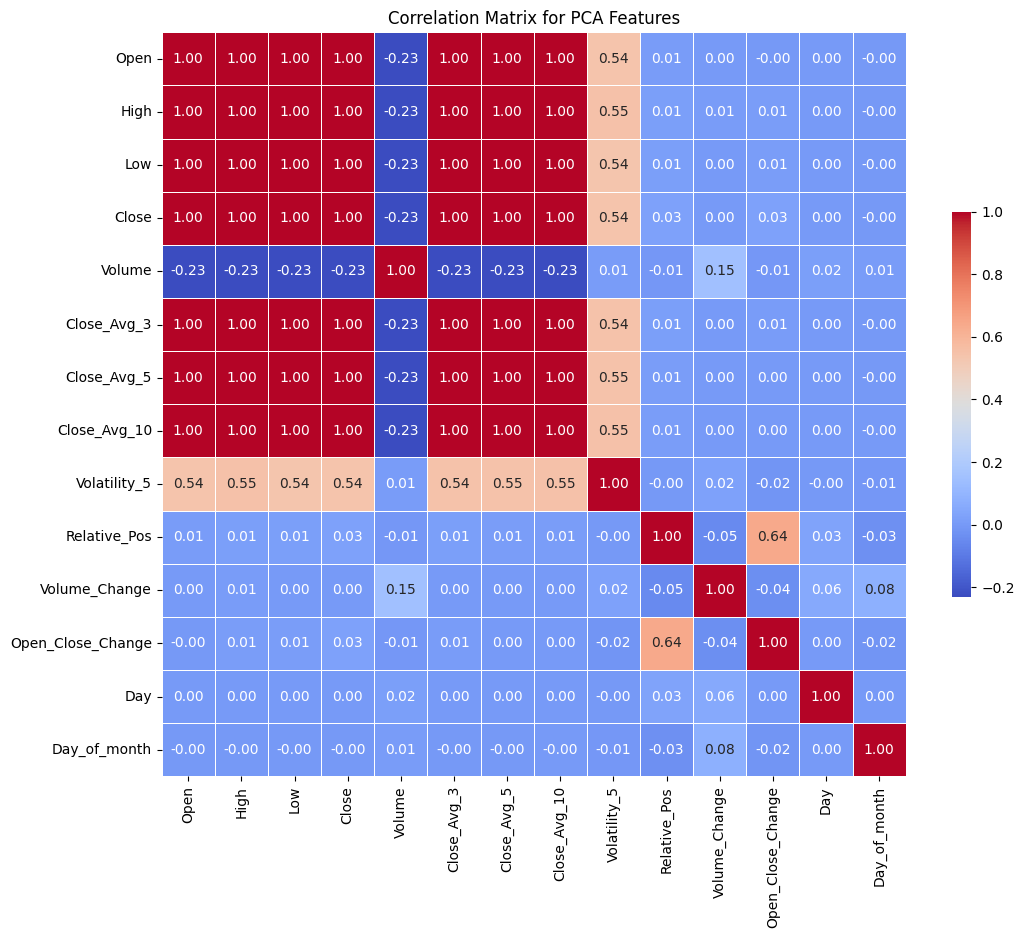

In [399]:
import seaborn as sns
import matplotlib.pyplot as plt

featuresK = [f for f in df.columns if f not in ['Date', 'Symbol', 'Raw_close', 'Raw_open_close', 'Raw_volume']]
# Select only the relevant features for the correlation matrix
df_for_corr = df[featuresK]

# Calculate the correlation matrix
corr_matrix = df_for_corr.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix for PCA Features')
plt.show()


For the Conditional Variational Autoencoder CVAE, it is essential to condition the model on the labels represented by stock symbols. These symbols are first converted to integer labels using `LabelEncoder` and subsequently one-hot encoded. This transforms the label into a binary matrix representation which is necessary for conditioning the model on categorical input features. The transformation ensures each category is equally distant from each other, mitigating any ordinal relationships that might be misinterpreted by the model.

In [400]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label = df['Symbol']

le= LabelEncoder().fit(label)
encoded_Y = le.transform(label)  # convert categorical labels to integers

dummy_y = np_utils.to_categorical(encoded_Y)

print(dummy_y[:4])

num_symbols = max(encoded_Y)
print(num_symbols)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
28


In an attempt to refine the model's performance and encapsulate the temporal dynamics more accurately, we introduced cyclic transformations of time-related features. These transformations include sine and cosine functions of the day of the month and the day of the week. Such cyclic features should help in modeling patterns that are dependent on the time of year or week.
Despite the theoretical advantages, these cyclic features did not improve the model's performance in practical scenarios. Consequently, they were not included in the final model configuration.


In [401]:
max_day_of_month = 31  # maximum day in month
max_day_of_week = 7    # maximum day in week

df['Day_of_month_sin'] = np.sin(2 * np.pi * df['Day_of_month'] / max_day_of_month)
df['Day_of_month_cos'] = np.cos(2 * np.pi * df['Day_of_month'] / max_day_of_month)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / max_day_of_week)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / max_day_of_week)


print(df.columns)

Index(['Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_Avg_3',
       'Close_Avg_5', 'Close_Avg_10', 'Volatility_5', 'Relative_Pos',
       'Volume_Change', 'Open_Close_Change', 'Day', 'Day_of_month', 'Date',
       'Raw_volume', 'Raw_open_close', 'Raw_close', 'Day_of_month_sin',
       'Day_of_month_cos', 'Day_sin', 'Day_cos'],
      dtype='object')


The dataset is split into training, validation, and test sets to ensure a evaluation framework. 20% of the data is reserved for testing, and of the remaining 80%, 10% is further reserved for validation. 

Additionally, a subset of the dataset is prepared for anomaly detection. The last 100 data points of a particular stock. This subset will be used to scrutinize the model's performance on detecting anomalies within known patterns of that stock.  A corresponding segment of the one-hot encoded labels is adjusted to focus on the stock of interest, ensuring that during anomaly testing, the model's predictions can be accurately assessed against the intended target.



In [402]:
from sklearn.model_selection import train_test_split

# Save the stock of interest for anomaly testing
stock_symbol_identifier = 0

def prepare_data_for_anomaly_detection(df, symbol_identifier, lookback=100):
    print('Generate stock data for:', le.classes_[symbol_identifier])
    df_stock = df[df['Symbol'] == le.classes_[symbol_identifier]].tail(lookback)
    stock_indices = df.index[-lookback:]
    stock_dummy = np.zeros((lookback, len(le.classes_)))  # Initialize zero matrix
    stock_dummy[:, symbol_identifier] = 1  # Set the column for the symbol to 1
    return df_stock, stock_dummy

df_stock, stock_dummy = prepare_data_for_anomaly_detection(df, stock_symbol_identifier)

print(df.columns)
# Split dataset into training, validation, and test sets
features = [f for f in df.columns if f not in ['Date', 'Symbol', 'Raw_close', 'Raw_open_close', 'Raw_volume','Day_of_month_sin', 'Day_of_month_cos', 'Day_sin', 'Day_cos',
                                                'Open', 'High', 'Low','Close_Avg_3', 'Close_Avg_5', 'Close_Avg_10', 'Relative_Pos']]
X = df[features]
y = dummy_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=26)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=89)

# Create a copy of the test set with symbol and date for further analysis
X_test_with_symbol = X_test.copy()

# Remove non-feature columns for model input preparation
X_test = X_test[features]
X_train = X_train[features]
X_valid = X_valid[features]

print("X shape: ", X_train.shape, X_valid.shape, X_test.shape)
print("Y shape: ", y_train.shape, y_valid.shape, y_test.shape)

print(features)

Generate stock data for: AAPL
Index(['Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_Avg_3',
       'Close_Avg_5', 'Close_Avg_10', 'Volatility_5', 'Relative_Pos',
       'Volume_Change', 'Open_Close_Change', 'Day', 'Day_of_month', 'Date',
       'Raw_volume', 'Raw_open_close', 'Raw_close', 'Day_of_month_sin',
       'Day_of_month_cos', 'Day_sin', 'Day_cos'],
      dtype='object')
X shape:  (26078, 7) (2898, 7) (7245, 7)
Y shape:  (26078, 29) (2898, 29) (7245, 29)
['Close', 'Volume', 'Volatility_5', 'Volume_Change', 'Open_Close_Change', 'Day', 'Day_of_month']


To ensure consistent batch sizes during model training, data is truncated to include only complete batches. The process involves:

1. **Calculating the number of complete batches** for the training, validation, and test datasets based on a predefined batch size.
2. **Truncating the datasets** to the maximum number that fits into these complete batches. This means any excess records at the end of the dataset that don't fill up a complete batch are discarded.

This handling is important for ensuring that gradient updates are performed consistently across all batches during training.


In [403]:
m = 32  # batch size

# Calculate number of complete batches for training data
num_batches_train = X_train.shape[0] // m
X_train_trun = X_train.iloc[:num_batches_train * m]
y_train_trun = y_train[:num_batches_train * m, :]
print("Training set truncated to:", X_train_trun.shape, y_train_trun.shape)

# Calculate number of complete batches for validation data
num_batches_valid = X_valid.shape[0] // m
X_valid_trun = X_valid.iloc[:num_batches_valid * m]
y_valid_trun = y_valid[:num_batches_valid * m, :]
print("Validation set truncated to:", X_valid_trun.shape, y_valid_trun.shape)

# Calculate number of complete batches for testing data
num_batches_test = X_test.shape[0] // m
X_test_trun = X_test.iloc[:num_batches_test * m]
y_test_trun = y_test[:num_batches_test * m, :]
print("Testing set truncated to:", X_test_trun.shape, y_test_trun.shape)

Training set truncated to: (26048, 7) (26048, 29)
Validation set truncated to: (2880, 7) (2880, 29)
Testing set truncated to: (7232, 7) (7232, 29)


## Conditional Variational Autoencoder (CVAE) Model Definition

This CVAE is conditioned on the stock symbols to capture stock-specific characteristics in its latent space representation. The model is structured into two main components: an encoder and a decoder, with a custom sampling layer facilitating the variational aspect of the model.

The model accepts two inputs: `encoder_input` (features) and `label_input` (conditions), allowing it to learn conditional distributions.
- **Encoder**: First, the features and labels are concatenated. This merged input is then passed through a dense layer (`encoder_h`) with ReLU activation to create a hidden representation. From here, two paths emerge where dense layers output the parameters for the latent space distribution.
- **Latent Space**: Utilizes the `Sampling` layer which uses the parameters `z_mean` and `z_log_var` to sample from the latent space. By introducing randomness through `epsilon`, a standard normal variable, it enables the model to generate diverse outputs. 
- **Decoder**: The sampled `z` is concatenated with the label again, ensuring that the output generation remains conditional on the label input. This combined vector is fed into another dense layer (`decoder_h`) and finally to an output layer that reconstructs the original input dimensionality.
  
- **Loss Calculation**: the model computes two losses:
  - **Reconstruction Loss**: Measures the fidelity of the reconstruction by comparing the original input `x` to the `final_output` using mean squared error.
  - **KL Divergence**: Quantifies the difference between the learned latent distribution and the prior distribution (assumed standard normal), acting as a regularizer.
  - The total loss, which includes a weighted sum of the reconstruction loss and the KL divergence (`beta * kl_loss`), is added to the model's losses during training.





In [404]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape=(batch, K.int_shape(z_mean)[1]))
        return z_mean + K.exp(z_log_var / 2) * epsilon

class VAE(Model):
    def __init__(self, encoder_dim, decoder_dim, n_z,input_dim, label_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        # Input layers
        self.encoder_input = Input(shape=(input_dim,))
        self.label_input = Input(shape=(label_dim,))
        self.concat = Concatenate()
        
        # Encoder
        self.encoder_h = Dense(encoder_dim, activation='relu')
        self.z_mean = Dense(n_z)
        self.z_log_var = Dense(n_z)
        
        # Instantiate and use the Sampling layer
        self.sampling_layer = Sampling()
        
        # Decoder
        self.decoder_h = Dense(decoder_dim, activation='relu')
        self.outputs = Dense(input_dim, activation='sigmoid')

        
    def call(self, inputs,training=False,return_model_outputs=False):
        x, label = inputs
        merged = self.concat([x, label])
        h = self.encoder_h(merged)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        z = self.sampling_layer([z_mean, z_log_var])
        
        decoder_input = self.concat([z, label])
        x_decoded = self.decoder_h(decoder_input)
        final_output = self.outputs(x_decoded)
        

        if training:
            beta = 0.02
            reconstruction_loss = K.mean(K.square(x - final_output), axis=-1)
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            total_loss = reconstruction_loss + beta * kl_loss
            self.add_loss(total_loss)

            self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
            self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')

        if return_model_outputs:
            return final_output, z_mean, z_log_var
        return final_output   

### Training


The training process for the CVAE model involves several steps that aim to optimize the model's parameters and ensure effective learning and generalization. Here is a detailed breakdown of the training workflow:

- **Model Setup**: An instance of the VAE model is created with specific dimensions for the encoder, decoder, and latent space. This setup includes dimensions for the input features and label data.
- **Optimizer**: The Adam optimizer is utilized with a learning rate of 0.001. Adam is chosen for its adaptive learning rate capabilities, which helps in converging faster and more efficiently.

##### Training Loop
- **Epochs and Batches**: The model is trained for a maximum of 50 epochs. Each epoch iterates over batches of data, processing both training and validation sets.
- **Forward Pass**: For each batch, data is fed into the model, which performs a forward pass generating the reconstructed output.
- **Loss Calculation**: The loss is computed as the mean squared error between the original input and its reconstruction, added to the accumulated losses from the VAE (KL divergence and reconstruction loss).
- **Backpropagation**: Gradients are calculated using TensorFlow's `GradientTape`, which is essential for automatic differentiation. These gradients are then applied to the model's parameters via the optimizer.
  
##### Validation and Early Stopping
- **Validation**: Simultaneously, the model's performance is evaluated on the validation dataset without affecting the model's weights. This helps in monitoring for overfitting.
- **Early Stopping**: To prevent overfitting and unnecessary computations, early stopping is implemented. If the validation loss does not improve for a consecutive `10` epochs, training is halted. This approach helps in saving the best model state, which achieved the lowest validation loss.


In [405]:
# Instantiate and compile the VAE
input_dim = X_train_trun.shape[1]
label_dim = y_train_trun.shape[1]
vae = VAE(encoder_dim=10, decoder_dim=10, n_z=3, input_dim=input_dim, label_dim=label_dim)


# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_trun, y_train_trun)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid_trun, y_valid_trun)).batch(32)

# Variables to track the best model and early stopping
best_val_loss = np.inf
patience = 10 
patience_counter = 0

# Iterate over epochs.
train_losses = []
val_losses = []

for epoch in range(50):
    print("\nStart of epoch %d" % (epoch,))
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()

    # Training loop
    for x_batch_train, y_batch_train in train_dataset:
        x_batch_train = tf.cast(x_batch_train, tf.float32)
        y_batch_train = tf.cast(y_batch_train, tf.float32)
        with tf.GradientTape() as tape:
            reconstructed = vae((x_batch_train, y_batch_train), training=True)
            loss = tf.reduce_mean(tf.square(tf.subtract(x_batch_train, reconstructed)))
            loss += sum(vae.losses)
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        epoch_loss_avg.update_state(loss)
    
    train_losses.append(epoch_loss_avg.result())

    # Validation loop
    for x_batch_val, y_batch_val in val_dataset:
        x_batch_val = tf.cast(x_batch_val, tf.float32)
        y_batch_val = tf.cast(y_batch_val, tf.float32)
        val_reconstructed = vae((x_batch_val, y_batch_val), training=False)
        val_loss = tf.reduce_mean(tf.square(tf.subtract(x_batch_val, val_reconstructed)))
        val_loss_avg.update_state(val_loss)
    
    val_losses.append(val_loss_avg.result())
    print("End of epoch {}. Training loss: {:.4f}. Validation loss: {:.4f}".format(epoch, epoch_loss_avg.result(), val_loss_avg.result()))

    # Check for early stopping conditions
    if val_loss_avg.result() < best_val_loss:
        best_val_loss = val_loss_avg.result()
        patience_counter = 0  # Reset patience since we have a new best validation loss
        # Save the model state if necessary
        vae.save_weights('best_vae_weights.h5')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Stopping early after {} epochs.".format(epoch + 1))
            break

# Load the best model weights back into the model
vae.load_weights('best_vae_weights.h5')


Start of epoch 0
End of epoch 0. Training loss: 0.1148. Validation loss: 0.0301

Start of epoch 1
End of epoch 1. Training loss: 0.0560. Validation loss: 0.0182

Start of epoch 2
End of epoch 2. Training loss: 0.0471. Validation loss: 0.0127

Start of epoch 3
End of epoch 3. Training loss: 0.0453. Validation loss: 0.0115

Start of epoch 4
End of epoch 4. Training loss: 0.0445. Validation loss: 0.0113

Start of epoch 5
End of epoch 5. Training loss: 0.0443. Validation loss: 0.0116

Start of epoch 6
End of epoch 6. Training loss: 0.0442. Validation loss: 0.0112

Start of epoch 7
End of epoch 7. Training loss: 0.0439. Validation loss: 0.0109

Start of epoch 8
End of epoch 8. Training loss: 0.0437. Validation loss: 0.0112

Start of epoch 9
End of epoch 9. Training loss: 0.0440. Validation loss: 0.0112

Start of epoch 10
End of epoch 10. Training loss: 0.0436. Validation loss: 0.0110

Start of epoch 11
End of epoch 11. Training loss: 0.0436. Validation loss: 0.0111

Start of epoch 12
End o

## Model Evaluation

Visualizing Training and Validation Loss provides insight into the learning progression of the model across epochs. Both the training and validation loss decrease sharply in the initial epochs, suggesting rapid learning and adaptation by the model to the underlying patterns in the data.



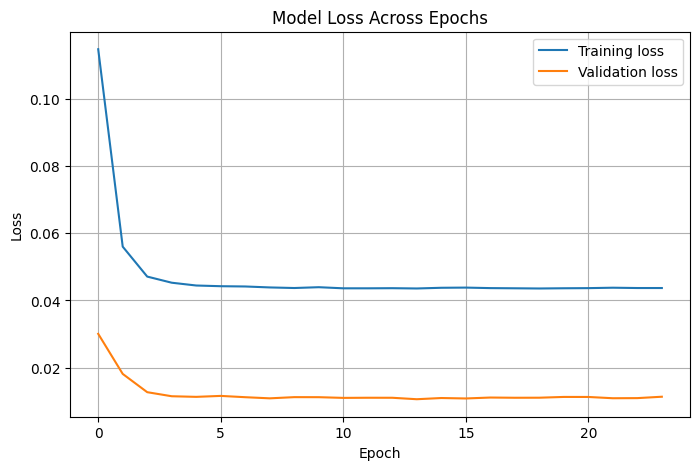

In [406]:
# Plotting the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


This visualization consists of bar charts arranged in two rows: the top row displays the original data, while the bottom row shows the reconstructed data. Each column corresponds to a sample from the validation dataset, allowing a direct visual comparison to assess the model's reconstruction accuracy.

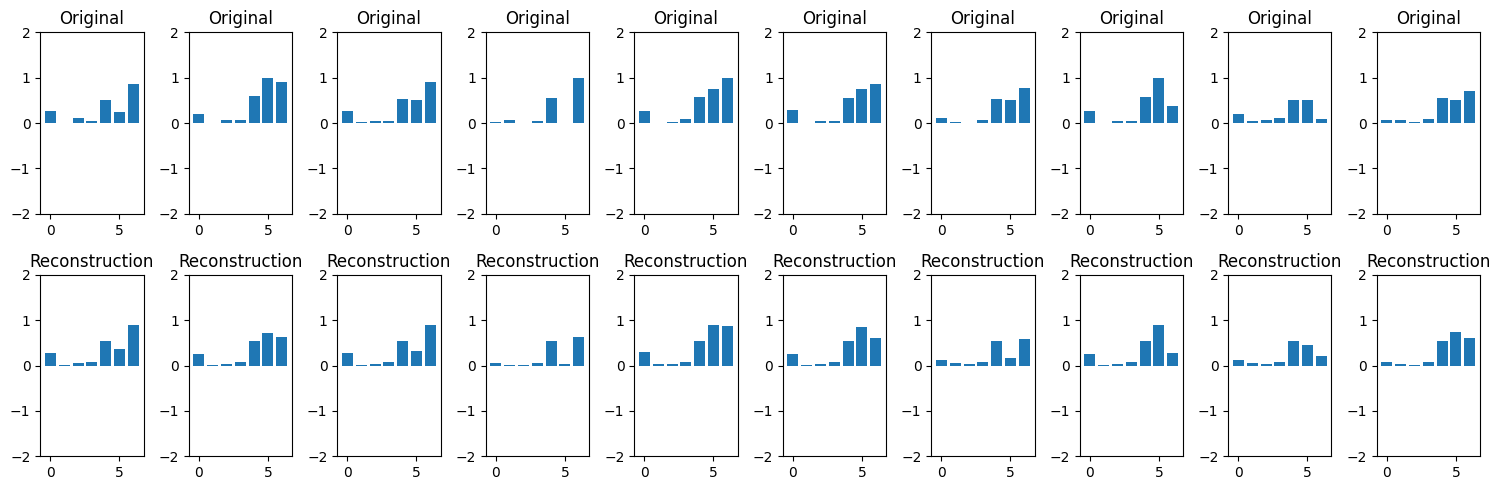

In [407]:
for test_samples, test_labels in val_dataset.take(1):  # Take just one batch
    reconstructions = vae((test_samples, test_labels), training=False)

    plt.figure(figsize=(15, 5))
    num_samples_to_display = 10  
    for i in range(num_samples_to_display):
        plt.subplot(2, num_samples_to_display, i + 1)
        plt.bar(range(len(test_samples[i].numpy())), test_samples[i].numpy())
        plt.title("Original")
        plt.ylim([-2, 2])  
        
        plt.subplot(2, num_samples_to_display, num_samples_to_display + i + 1)
        plt.bar(range(len(reconstructions[i].numpy())), reconstructions[i].numpy())
        plt.title("Reconstruction")
        plt.ylim([-2, 2]) 
        
    plt.tight_layout()
    plt.show()


### Anomaly Detection

This section of the code is dedicated to detecting anomalies in the test dataset using the trained Conditional Variational Autoencoder (CVAE). The procedure involves the following steps:

1. **Model Inference**: For each batch of test data, the model predicts the reconstructed outputs along with the latent variables (`z_mean`, `z_log_var`).
2. **Error Calculation**: The reconstruction error for each sample is computed as the mean squared error between the original and reconstructed data.
3. **Error Aggregation**: Reconstruction errors are collected across all test batches to assess the model's performance over the entire dataset.
4. **Thresholding for Anomalies**: An anomaly threshold is set at the 95th percentile of the reconstruction errors, identifying the top 5% errors as anomalies.
6. **Visualization**: A plot is generated to visually assess the reconstruction errors against the anomaly threshold, highlighting the distribution of errors and the identified anomalies.

This approach enables the identification of data points that significantly deviate from the model's learned distribution, flagged as potential anomalies.


Anomaly count: 363
Anomaly percentage: [0. 0. 0. ... 0. 0. 0.]


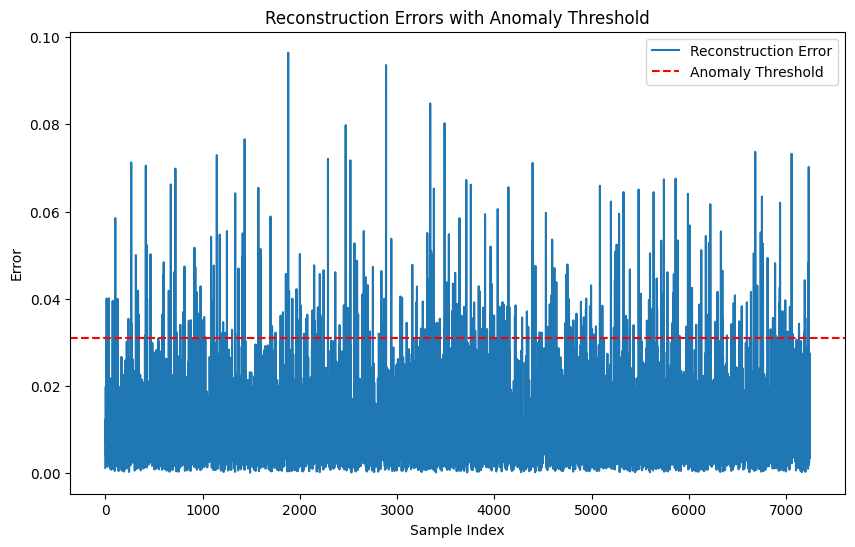

In [422]:
reconstructedd = [] 
recon_errors = []
z_means = []
z_log_vars = []
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test)).batch(20)

for x_batch_test, y_batch_test in test_dataset:
    reconstructed, z_mean, z_log_var = vae((x_batch_test, y_batch_test), return_model_outputs=True)
    error = np.mean(np.square(x_batch_test.numpy() - reconstructed.numpy()), axis=1)
    reconstructedd.extend(reconstructed.numpy())
    recon_errors.extend(error)
    z_means.extend(z_mean.numpy())
    z_log_vars.extend(z_log_var.numpy())

recon_errors = np.array(recon_errors)

threshold = np.percentile(recon_errors, 95)  # setting threshold at the 95th percentile
anomalies = recon_errors > threshold
print(f"Anomaly count: {np.sum(anomalies)}")
anomaly_percentage = anomalies / len(recon_errors)
print("Anomaly percentage:", anomaly_percentage)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(recon_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.title('Reconstruction Errors with Anomaly Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Error')
plt.show()


Perform a detailed analysis to quantify the contribution of each feature in the test dataset to the reconstruction error. The features 'Relative_Pos', 'Day_of_month', and 'Close_Avg_10' stand out as having the highest contributions to the errors, suggesting these aspects of the data are the most challenging for the model to reconstruct accurately. 

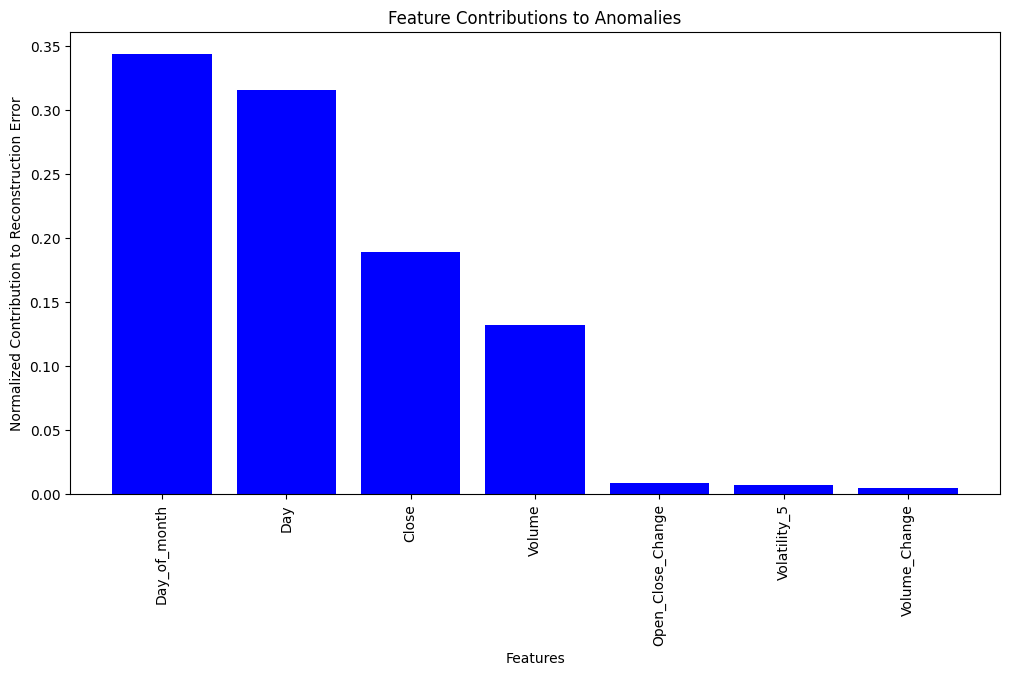

In [421]:
feature_contributions = np.zeros(len(X_test.columns))  # Initialize the contribution array


for x_batch_test, y_batch_test in test_dataset:
    x_batch_test = tf.cast(x_batch_test, tf.float32)
    
    reconstructed, _, _ = vae((x_batch_test, y_batch_test), return_model_outputs=True)
    reconstructed = tf.cast(reconstructed, tf.float32)
    
    # Check shapes
    assert x_batch_test.shape == reconstructed.shape, "Shape mismatch between inputs and reconstruction"
    
    # Calculate squared differences
    squared_errors = tf.square(x_batch_test - reconstructed)
    # Sum across the batch for each feature
    batch_contributions = tf.reduce_sum(squared_errors, axis=0)
    # Accumulate contributions from each batch
    feature_contributions += batch_contributions.numpy()

# Normalize the feature contributions
feature_contributions_normalized = feature_contributions / np.sum(feature_contributions)

# Create DataFrame for plotting
features_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Contribution': feature_contributions_normalized
}).sort_values(by='Contribution', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(features_df['Feature'], features_df['Contribution'], color='b')
plt.xlabel('Features')
plt.ylabel('Normalized Contribution to Reconstruction Error')
plt.title('Feature Contributions to Anomalies')
plt.xticks(rotation=90)
plt.show()

### Visualization of the Latent Space

The latent space is a lower-dimensional representation of the data, where similar data points cluster together, and differences are highlighted in separate dimensions. Points are color-coded based on their respective reconstruction errors. The purpose of this visualization is to understand how well the model captures the data complexity and to identify any potential anomalies or patterns in the latent space that could indicate issues with data reconstruction.



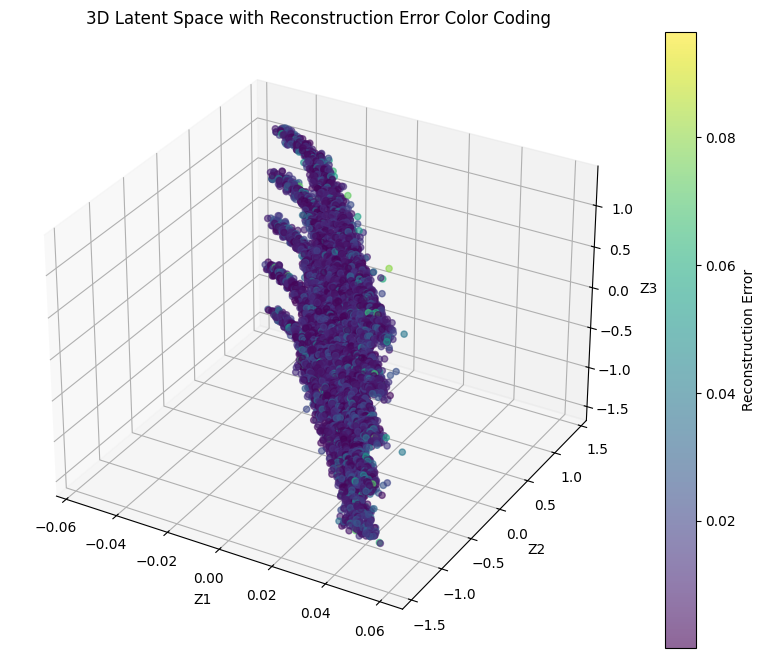

In [423]:
z_means = np.array(z_means)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use reconstruction errors as the color scale
sc = ax.scatter(z_means[:, 0], z_means[:, 1], z_means[:, 2], c=recon_errors, cmap='viridis', alpha=0.6)

ax.set_xlabel('Z1')
ax.set_ylabel('Z2')
ax.set_zlabel('Z3')
plt.title('3D Latent Space with Reconstruction Error Color Coding')
plt.colorbar(sc, label='Reconstruction Error')

plt.show()


The output from the t-SNE a machine learning algorithm for dimensionality reduction, to visualize the high-dimensional latent space of the trained VAE model in two dimensions.



The model is designed to handle stock prices, where it learns to reconstruct input data conditioned on categorical labels (stock symbols). By incorporating these labels, the CVAE's latent space is conditioned to reflect specific characteristics of each stock, allowing it to generate different outputs for the same latent point based on the conditioned symbol.


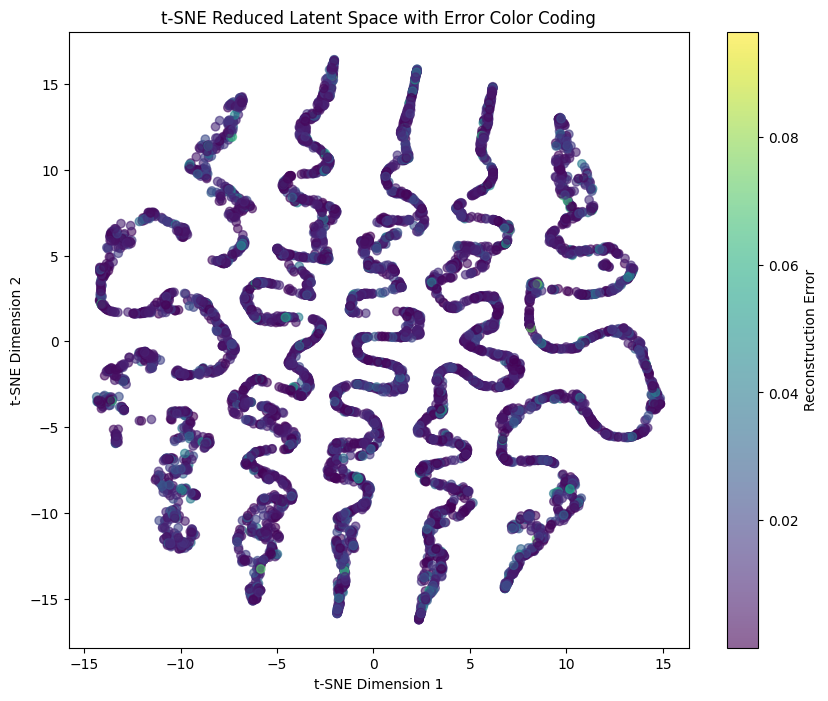

In [424]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
z_tsne = tsne.fit_transform(z_means)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(z_tsne[:, 0], z_tsne[:, 1], c=recon_errors, cmap='viridis', alpha=0.6)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Reconstruction Error')
plt.title('t-SNE Reduced Latent Space with Error Color Coding')
plt.show()

In a Conditional Variational Autoencoder, the latent space visualization may not show clear clustering when conditioned on different stock symbols, as each symbol introduces unique characteristics to the model's understanding of the data. This conditionality means that identical points in the latent space could represent different scenarios across various stocks. As a result, what appears as an anomaly for one stock may not be unusual for another. This aspect can complicate interpreting clusters within the latent space as they are influenced by the specific contexts of each stock.

In [412]:
# Ensure X_test_with_symbol is prepared to include all test examples in the correct order
X_test_with_symbol['recon_error'] = recon_errors

# Filter rows where the reconstruction error exceeds the threshold
anomalous_data = X_test_with_symbol[X_test_with_symbol['recon_error'] > threshold]
sorted_anomalies = anomalous_data.sort_values('recon_error', ascending=False)
print(sorted_anomalies)

          Close    Volume  Volatility_5  Volume_Change  Open_Close_Change  \
29235  0.349514  0.048702      0.814901       0.041808           0.465124   
8168   0.085394  0.091938      0.038381       0.097296           0.531684   
16713  0.207664  0.098134      0.126982       0.111668           0.482203   
5349   0.039017  0.069581      0.044614       0.081745           0.562330   
22665  0.383600  0.009614      0.050021       0.058038           0.546688   
...         ...       ...           ...            ...                ...   
16536  0.226066  0.020461      0.010251       0.022668           0.558819   
30272  0.075123  0.037182      0.008725       0.059911           0.548603   
27976  0.302559  0.018637      0.381719       0.111368           0.392498   
35980  0.082147  0.066096      0.015424       0.079952           0.549561   
14405  0.332239  0.004532      0.026877       0.069838           0.555674   

        Day  Day_of_month  recon_error  
29235  1.00      0.400000     0.11

## Anomaly detection for AAPL's stock

The procedure detailed is designed for anomaly detection within the historical data of the AAPL stock. The anomalies are defined as data points where the reconstruction error exceeds a dynamically calculated threshold AAPL's stock history.

Anomaly threshold: 0.02722607406517391


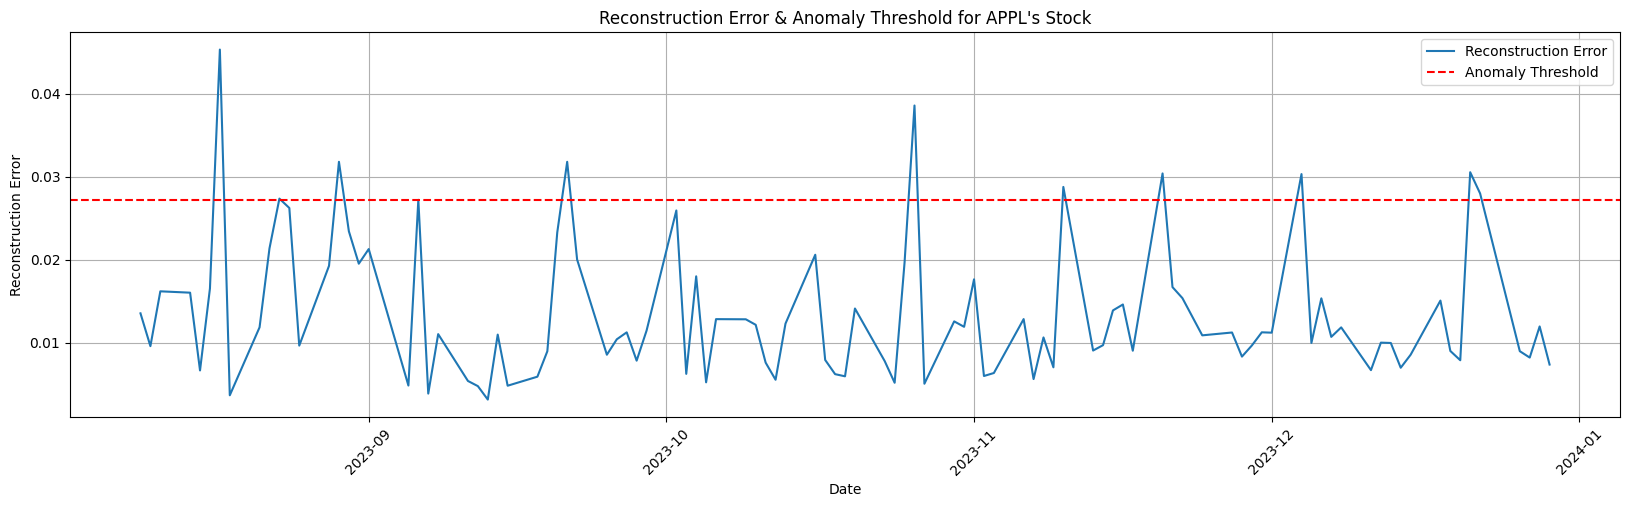

Detected anomalies:
            Date  recon_error
26324 2023-08-17     0.045313
26328 2023-08-23     0.027358
26332 2023-08-29     0.031793
26348 2023-09-21     0.031791
26373 2023-10-26     0.038575
26384 2023-11-10     0.028764
26390 2023-11-20     0.030390
26399 2023-12-04     0.030312
26412 2023-12-21     0.030539
26413 2023-12-22     0.027977


In [419]:
# Prepare APPL dataset for prediction
df_stock_features = df_stock[features].values
stock_dummy = stock_dummy.astype(np.float32)

test_dataset = tf.data.Dataset.from_tensor_slices((df_stock_features, stock_dummy)).batch(20)


# Use the VAE to predict z-space and reconstructions
recon_on_generated_stock = []
z_means = []
z_log_vars = []

for x_batch_test, y_batch_test in test_dataset:
    reconstructed, z_mean, z_log_var = vae((x_batch_test, y_batch_test), return_model_outputs=True)
    errors = np.mean(np.square(x_batch_test.numpy() - reconstructed.numpy()), axis=1)
    recon_on_generated_stock.extend(errors)
    z_means.extend(z_mean.numpy())
    z_log_vars.extend(z_log_var.numpy())

# Determine the anomaly threshold
recon_se = pd.Series(recon_on_generated_stock)
anomaly_threshold = np.percentile(recon_se, 90)
print('Anomaly threshold:', anomaly_threshold)

# Annotate data with errors and detect anomalies
df_stock['recon_error'] = recon_on_generated_stock
anomalies = df_stock[df_stock['recon_error'] > anomaly_threshold]

# Plotting the results
plt.figure(figsize=(20, 5))
plt.plot(df_stock['Date'], df_stock['recon_error'], label='Reconstruction Error')
plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.title("Reconstruction Error & Anomaly Threshold for APPL's Stock")
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Output detected anomalies
print("Detected anomalies:")
print(anomalies[['Date', 'recon_error']])

Visualize anomalies in time-series data for specific stock features like closing price, volume, and the difference between open and close prices.
This method effectively visualizes significant deviations in stock behavior, facilitating easy identification of days with unusual trading patterns or price movements, which could be indicative of anomalies.
isualize anomalies in time-series data for specific stock features like closing price, volume, and the difference between open and close prices. Here's how it works:


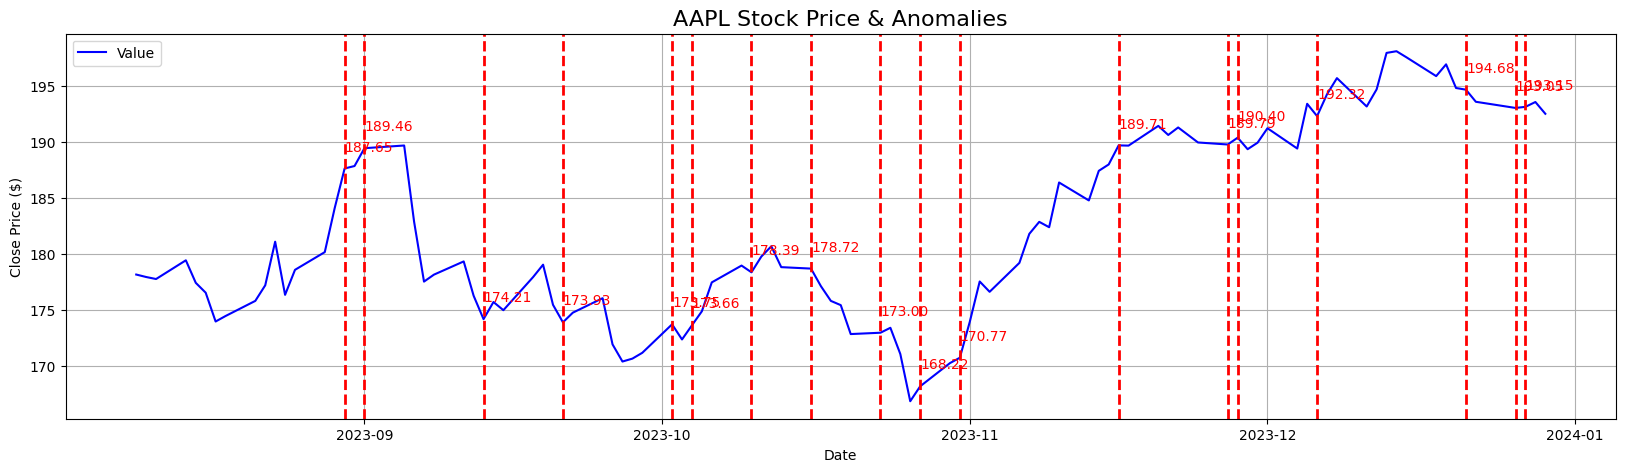

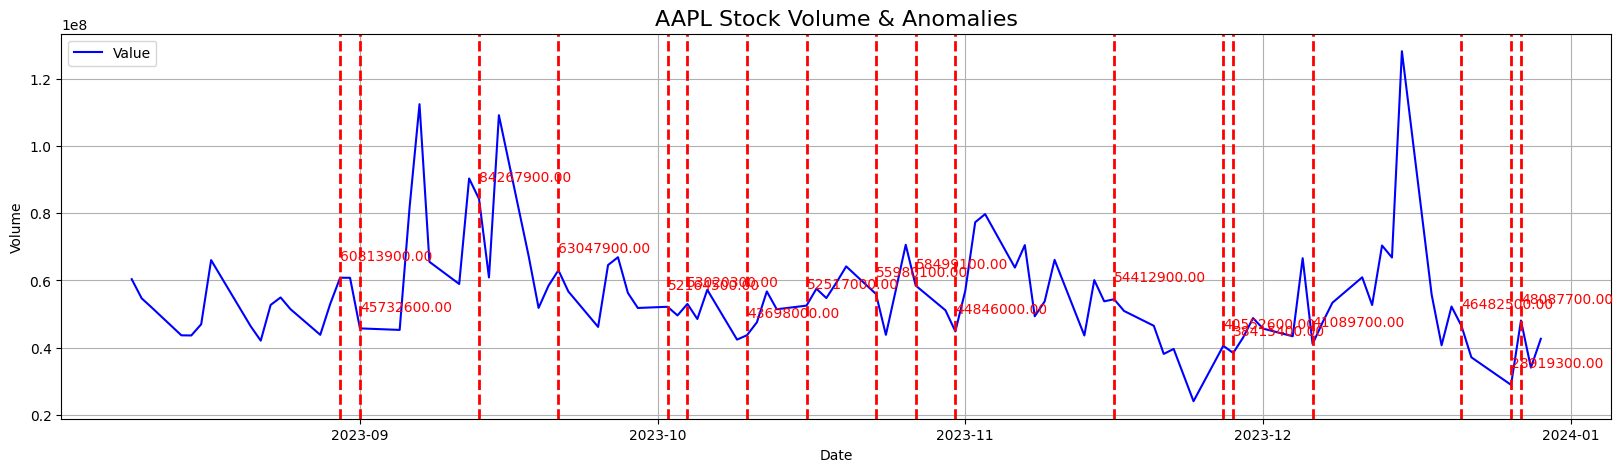

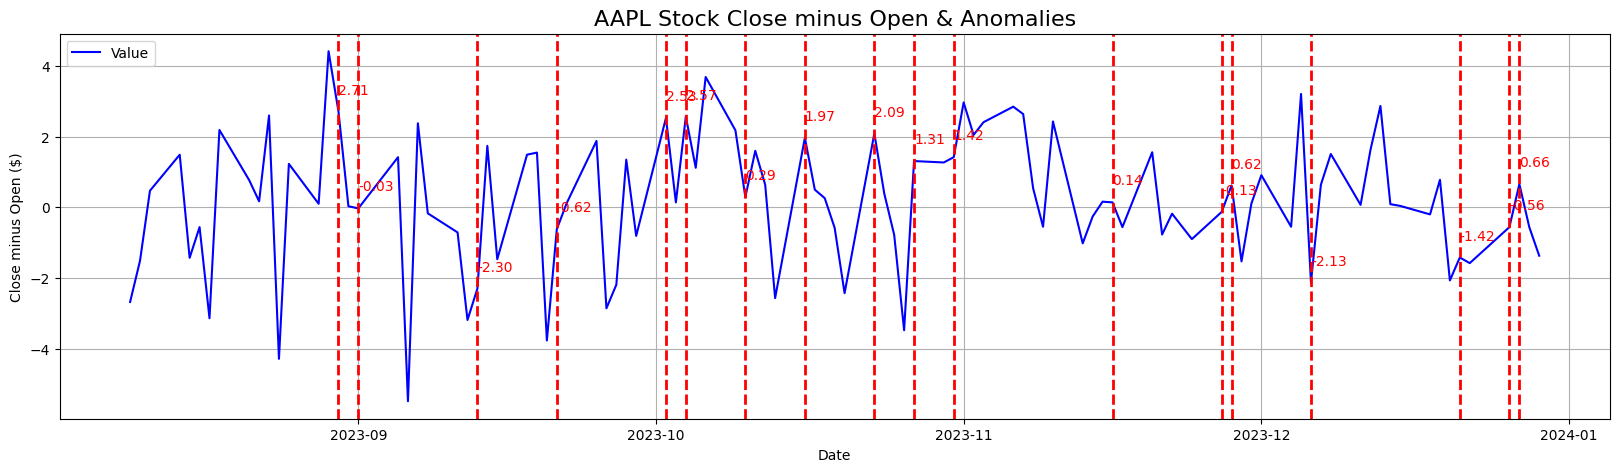

In [414]:
# Define a function to plot time series data
reconstructed_outputs, _, _ = vae((df_stock_features, stock_dummy), return_model_outputs=True)
reconstruction_errors = np.mean(np.square(df_stock_features - reconstructed_outputs.numpy()), axis=1)

# Add the reconstruction errors to your DataFrame
df_stock['recon_error'] = reconstruction_errors


def plot_time_series(data, y, title, ylabel, threshold):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data['Date'], data[y], label='Value', color='blue')
    ax.grid(True)
    
    # Annotate anomalies based on the threshold
    for index, row in data.iterrows():
        if row['recon_error'] > threshold:
            ax.axvline(x=row['Date'], color='red', linestyle='--', lw=2)
            ax.text(row['Date'], row[y] + (data[y].max() - data[y].min()) * 0.05, f'{row[y]:.2f}', color='red')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Call the function for each feature
plot_time_series(df_stock, 'Raw_close', 'AAPL Stock Price & Anomalies', 'Close Price ($)', anomaly_threshold)
plot_time_series(df_stock, 'Raw_volume', 'AAPL Stock Volume & Anomalies', 'Volume', anomaly_threshold)
plot_time_series(df_stock, 'Raw_open_close', 'AAPL Stock Close minus Open & Anomalies', 'Close minus Open ($)', anomaly_threshold)

Notably, peaks in the stock price and volume, as well as substantial intra-day price movements, are highlighted as anomalies. These points often coincide, suggesting that the anomalies across different metrics may be related to the same trading events or market conditions.